In [1]:
# -*- coding: utf-8 -*-
import os
import warnings
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import shap
import pickle

# Suppress warnings
warnings.filterwarnings("ignore")

In [2]:
# Load and process data function
def dataloader(filepath):
    raw_data = pd.read_csv(filepath)
    med_columns = raw_data.columns[raw_data.columns.str.contains('Med_')]
    raw_data[med_columns] = raw_data[med_columns].fillna(0)
    columns_to_rename = raw_data.columns[65:273]
    new_column_names = [col.rsplit('_', 1)[0] for col in columns_to_rename]
    raw_data.rename(columns=dict(zip(columns_to_rename, new_column_names)), inplace=True)
    filtered_df = raw_data[raw_data['Is transferred to ICU'] == 1].drop('Is transferred to ICU', axis=1, errors='ignore')
    transform_dtypes_data = filtered_df.copy().iloc[:, 2:]
    category_columns_1 = transform_dtypes_data.columns[
        transform_dtypes_data.columns.str.contains('Med_') | transform_dtypes_data.columns.str.startswith('Diagnosis_')
    ]
    transform_dtypes_data[category_columns_1] = transform_dtypes_data[category_columns_1].applymap(lambda x: 0 if x == 0.0 else 1)
    category_columns_2 = ['Gender', 'Insurance', 'Race', 'triage_Acuity', 'Arrival transport']
    transform_dtypes_data[category_columns_1] = transform_dtypes_data[category_columns_1].astype('category')
    transform_dtypes_data[category_columns_2] = transform_dtypes_data[category_columns_2].astype('category')
    # print(transform_dtypes_data.dtypes)

    def remove_outliers(df):
        for column in df.columns:
            if pd.api.types.is_numeric_dtype(df[column]):
                lower_bound = df[column].quantile(0.01)
                upper_bound = df[column].quantile(0.99)
                df[column] = df[column].apply(lambda v: lower_bound if v < lower_bound else upper_bound if v > upper_bound else v)
            if column == 'Age':
                df[column] = df[column].apply(lambda v: 91 if v > 91 else v)

        return df
    
    data = remove_outliers(transform_dtypes_data)
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1].squeeze()  # Ensure y is a 1D Series
    return X, y

# Feature selection function
def select_features(X, selected_features):
    print(f'Selected feature count: {len(selected_features)}')
    return X[selected_features]

# Model training and evaluation function
def train_and_evaluate(X, y, save_path, params=None):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    train_data = lgb.Dataset(X_train, label=y_train)
    default_params = {
        "learning_rate": 0.01,
        "boosting_type": "gbdt",
        "objective": "binary",
        "metric": ['auc', 'binary_logloss'],
        'max_depth': 5,
        'verbosity': -1,
    }
    params = params or default_params
    model = lgb.train(params, train_data, 1000)

    # Train and Test metrics
    for split, (X_split, y_split) in {'train': (X_train, y_train), 'test': (X_test, y_test)}.items():
        y_pred_proba = model.predict(X_split)
        auroc = roc_auc_score(y_split, y_pred_proba)
        precision, recall, _ = precision_recall_curve(y_split, y_pred_proba)
        auprc = auc(recall, precision)
        print(f"{split.capitalize()} AUROC: {auroc}")
        print(f"{split.capitalize()} AUPRC: {auprc}")

    return model


In [5]:
cd = '/Users/hnwang/bmc/ihm_icu/fs_framework' 
raw_data_path = '/Users/hnwang/ihm/without_fillna/alldata.csv'
feature_importance_path = '/Users/hnwang/bmc/ihm_icu/fs_auc_step2-2/get_topK_importance_trend/LightGBM_SHAP_imp.csv'
save_path = cd + '/shap_data/'

if os.path.exists(save_path)==False:
    os.makedirs(save_path)
    
items_to_remove = {
    # "Race",
    "Lab_Absolute Basophil Count",
    "Lab_Absolute Eosinophil Count",
    "Lab_Absolute Monocyte Count",
    "Lab_Alkaline Phosphatase",
    "Lab_Basophils",
    "Lab_Eosinophils",
    "Lab_Immature Granulocytes",
    "Lab_MCHC",
    "Lab_MCH",
    "Lab_MCV",
    # "Med_583.0",
    "Lab_Monocytes",
    "Lab_RBC",
    "Lab_RDW-SD",
    "Lab_Specific Gravity",
    "Med_2747.0",
    "Med_224.0",
    "Med_530.0",
    "Med_2750.0",
    "Med_6094.0",
    "Med_156.0",
    "Med_409.0",
    "Med_225.0",
    "Med_457.0",
    "Med_805.0",
    "Med_320.0",
    # "Diagnosis_F10",
    # "Diagnosis_R53",
    # "triage_Temperature",
    # "triage_HeartRate",
    # "triage_RespiratoryRate"
    # "triage_SBP",
    # "triage_DBP",
    
}

X, y = dataloader(raw_data_path)

top_k=79
imp = pd.read_csv(feature_importance_path)
selected_features = imp.loc[:top_k-1, 'Name'].tolist()
selected_features = [item for item in selected_features if item not in items_to_remove]

In [4]:
X_selected = select_features(X, selected_features)

model = train_and_evaluate(X_selected, y, save_path)

# SHAP Analysis
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_selected)
shap_df = pd.DataFrame(shap_values[1], columns=X_selected.columns)
shap_df.to_csv(os.path.join(save_path, 'shap_values.csv'), index=False)
expected_value = explainer.expected_value[1]
np.save(os.path.join(save_path, 'expected_value.npy'), expected_value)

# Save Feature Importance
feature_importance = shap_df.abs().mean().sort_values(ascending=False).reset_index()
feature_importance.columns = ['Feature', 'Importance']
feature_importance.to_csv(os.path.join(save_path, 'shap_importance.csv'), index=False)

# Save Final Dataset
X_selected['IHM'] = y
X_selected.to_csv(os.path.join(save_path, 'fs3_data.csv'), index=False)

Selected feature count: 54
Train AUROC: 0.9235741721971871
Train AUPRC: 0.7163529394841337
Test AUROC: 0.8072618569468154
Test AUPRC: 0.3740753943218697


In [6]:
selected_features

['Age',
 'Lab_RDW',
 'Lab_Albumin',
 'Lab_Lymphocytes',
 'vitalsigns_Temperature',
 'Lab_Urea Nitrogen',
 'Lab_Lactate',
 'triage_SpO2',
 'triage_RespiratoryRate',
 'Lab_PT',
 'Lab_Glucose',
 'vitalsigns_HeartRate',
 'triage_SBP',
 'vitalsigns_RespiratoryRate',
 'Diagnosis_K92',
 'Lab_Platelet Count',
 'Lab_White Blood Cells',
 'Lab_Chloride',
 'Lab_Bilirubin',
 'Emergency department boarding time ',
 'Race',
 'Lab_Asparate Aminotransferase (AST)',
 'triage_Temperature',
 'Lab_Phosphate',
 'vitalsigns_SBP',
 'Lab_Sodium',
 'Lab_PTT',
 'Lab_Hematocrit',
 'Lab_Neutrophils',
 'triage_HeartRate',
 'Lab_Red Blood Cells',
 'Med_583.0',
 'Lab_Magnesium',
 'Lab_Absolute Lymphocyte Count',
 'Lab_Creatinine',
 'Lab_Potassium',
 'Lab_Anion Gap',
 'Lab_Bicarbonate',
 'vitalsigns_DBP',
 'Lab_Hemoglobin',
 'Lab_Calcium',
 'Lab_INR(PT)',
 'triage_DBP',
 'Diagnosis_J18',
 'Lab_Absolute Neutrophil Count',
 'Med_1247.0',
 'Diagnosis_F10',
 'Lab_pH',
 'Diagnosis_R50',
 'Lab_Alanine Aminotransferase (ALT)

## SETP 2: draw figures

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
cd = '/Users/hnwang/bmc/ihm_icu/fs_framework' 
search_path = os.path.join(cd, 'shap_data')
save_path = os.path.join(cd, 'shap_figure')
os.makedirs(save_path, exist_ok=True)



[(0.06042042671512178, 'Lab_Glucose'), (0.0627136760682713, 'Lab_Asparate Aminotransferase (AST)'), (0.0628469236442469, 'Lab_Platelet Count'), (0.06882643551760943, 'triage_RespiratoryRate'), (0.06977847199846363, 'vitalsigns_HeartRate'), (0.07814260608678121, 'Lab_PT'), (0.07885926391589382, 'Lab_White Blood Cells'), (0.09443550617084424, 'triage_SpO2'), (0.11135421096735147, 'vitalsigns_Temperature'), (0.11248184687909621, 'Lab_Lactate'), (0.11704288905648201, 'Lab_Urea Nitrogen'), (0.13555354776522013, 'Lab_Albumin'), (0.15635888131298548, 'Lab_Lymphocytes'), (0.22684428889101443, 'Lab_RDW'), (0.4727941919671467, 'Age')]


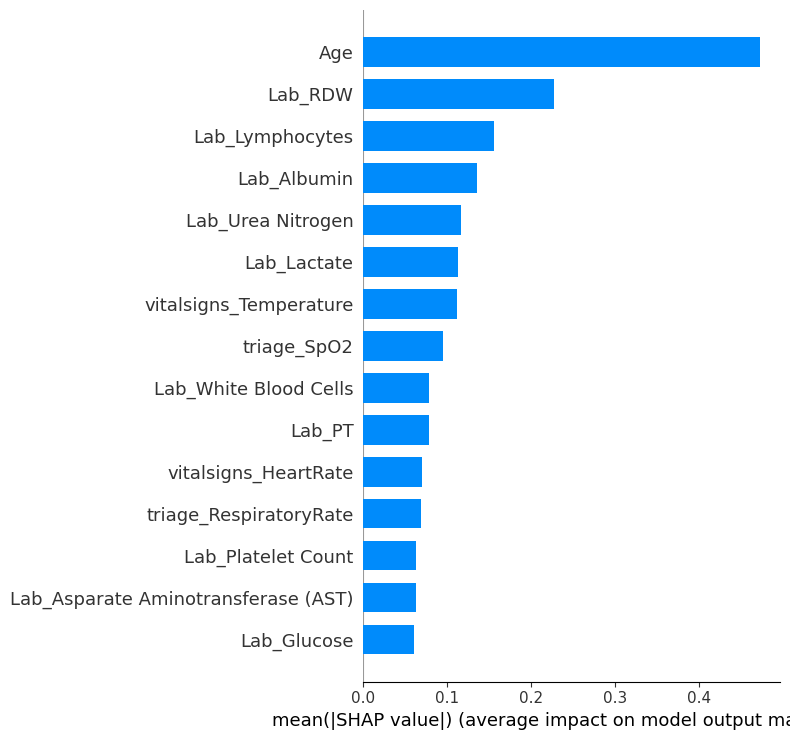

In [6]:
shap.summary_plot(shap_values[1], X_selected.iloc[:, :-1], plot_type="bar", max_display=15)

,Feature,Importance
0,Age,0.472794
1,Lab_RDW,0.226844
2,Lab_Lymphocytes,0.156359
3,Lab_Albumin,0.135554
4,Lab_Urea Nitrogen,0.117043
5,Lab_Lactate,0.112482
6,vitalsigns_Temperature,0.111354
7,triage_SpO2,0.094436
8,Lab_White Blood Cells,0.078859
9,Lab_PT,0.078143


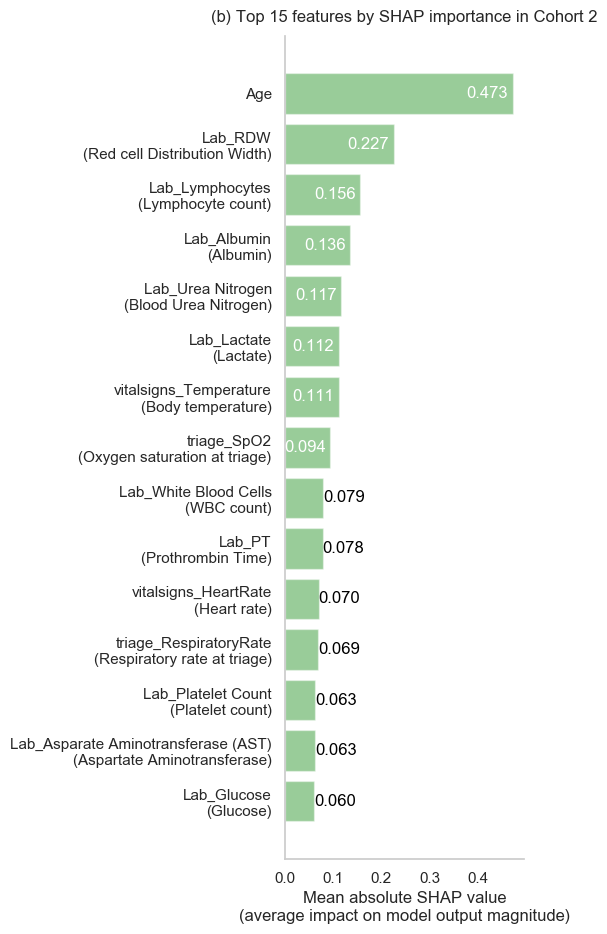

In [20]:
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.set_style("whitegrid", {'axes.grid': False})

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

top_features = feature_importance.head(15)
display(top_features)

top_features['Feature'] = [
    'Age',
    'Lab_RDW\n(Red cell Distribution Width)',
    'Lab_Lymphocytes\n(Lymphocyte count)',
    'Lab_Albumin\n(Albumin)',
    'Lab_Urea Nitrogen\n(Blood Urea Nitrogen)',
    'Lab_Lactate\n(Lactate)',
    'vitalsigns_Temperature\n(Body temperature)',
    'triage_SpO2\n(Oxygen saturation at triage)',
    'Lab_White Blood Cells\n(WBC count)',
    'Lab_PT\n(Prothrombin Time)',
    'vitalsigns_HeartRate\n(Heart rate)',
    'triage_RespiratoryRate\n(Respiratory rate at triage)',
    'Lab_Platelet Count\n(Platelet count)',
    'Lab_Asparate Aminotransferase (AST)\n(Aspartate Aminotransferase)',
    'Lab_Glucose\n(Glucose)'
]


plt.figure(figsize=(5.5, 9.5))
plt.barh(top_features['Feature'], top_features['Importance'], color='green', alpha=0.4)
for index, value in enumerate(top_features['Importance']):
    if index < 8:  # For the largest value, display on the left
        plt.text(value - 0.01, index, f"{value:.3f}", va='center', ha='right',  color='white')
    else:
        plt.text(value, index, f"{value:.3f}", va='center', ha='left', color='black')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.xlabel('Mean absolute SHAP value\n(average impact on model output magnitude)')
plt.title('(b) Top 15 features by SHAP importance in Cohort 2', fontsize=12, pad=10)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.grid(False)

plt.tight_layout()
plt.savefig(save_path + 'figure_top15features_MIMIC.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
def get_data():
    data = pd.read_csv(os.path.join(search_path, 'fs3_data.csv'))
    X = data.iloc[:, :-1]
    shap_values = pd.read_csv(os.path.join(search_path, 'shap_values.csv'))
    return X, shap_values

def get_values(fname, X, shap_values, ifprocess=False, weight=1):
    x = X[fname]
    s = shap_values[fname]
    
    if ifprocess:
        ind = x.notnull()
        x, s = x[ind], s[ind]
        x = (x * weight).astype(int)

    data = pd.DataFrame({fname: x, 'SHAP value': s})
    mean_value = data.groupby(fname)['SHAP value'].mean()
    sd = data.groupby(fname)['SHAP value'].std()
    
    return x, s, mean_value.index.values, mean_value.values, sd.values, mean_value

======figure is OK============
======figure is OK============
======figure is OK============
======figure is OK============


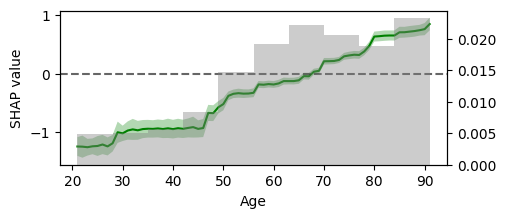

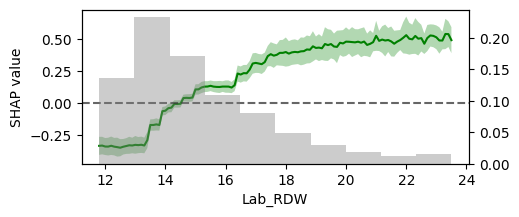

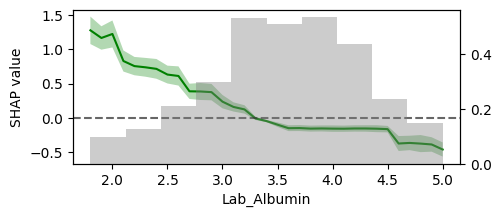

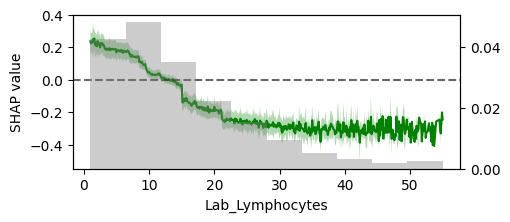

In [9]:
X,shap_values = get_data()

#============ draw figure
def draw_continuous_figure(fname,ifprocess,weight,xminmax,bins=None):
    x,s,xl,yl,sd, meanValue = get_values(fname,X,shap_values,ifprocess,weight)
    #plt.clf()
    fig = plt.figure(figsize=(5,2))
    ax1 = fig.add_subplot(111)
    #plt.errorbar(xl,yl,yerr=sd,xerr=0,fmt='o-',ecolor='b',color='r',capsize=4);
    ax1.fill_between(xl,yl+sd,yl-sd,facecolor='green',alpha=0.3)#
    ax1.plot(meanValue,'green');#'olive'
    ax1.axhline(y=0,linestyle='--',color='black',alpha=0.6)
    if xminmax==True:
        ax1.set_xlim(np.nanpercentile(x,1),np.nanpercentile(x,99))
    ax1.set_xlabel(fname)
    ax1.set_ylabel('SHAP value')    
    ax2 = ax1.twinx()
    ax2.hist(x, bins=bins, density=True, histtype='bar', color='grey',alpha=0.4)#'lightgrey',bisque'  density=True,
    #ax2.set_ylabel('Probability') 
       
    plt.savefig(save_path +'shap_'+fname+'.png',dpi=300, bbox_inches='tight')
    #plt.savefig(save_path +'shap_'+fname+'.pdf',dpi=300, bbox_inches='tight')
    #plt.show()
    print('======figure is OK============')

##### run
draw_continuous_figure('Age',False,1,False,)
draw_continuous_figure('Lab_RDW',False,1,False,)
draw_continuous_figure('Lab_Albumin',False,1,False,)
draw_continuous_figure('Lab_Lymphocytes',False,1,False)

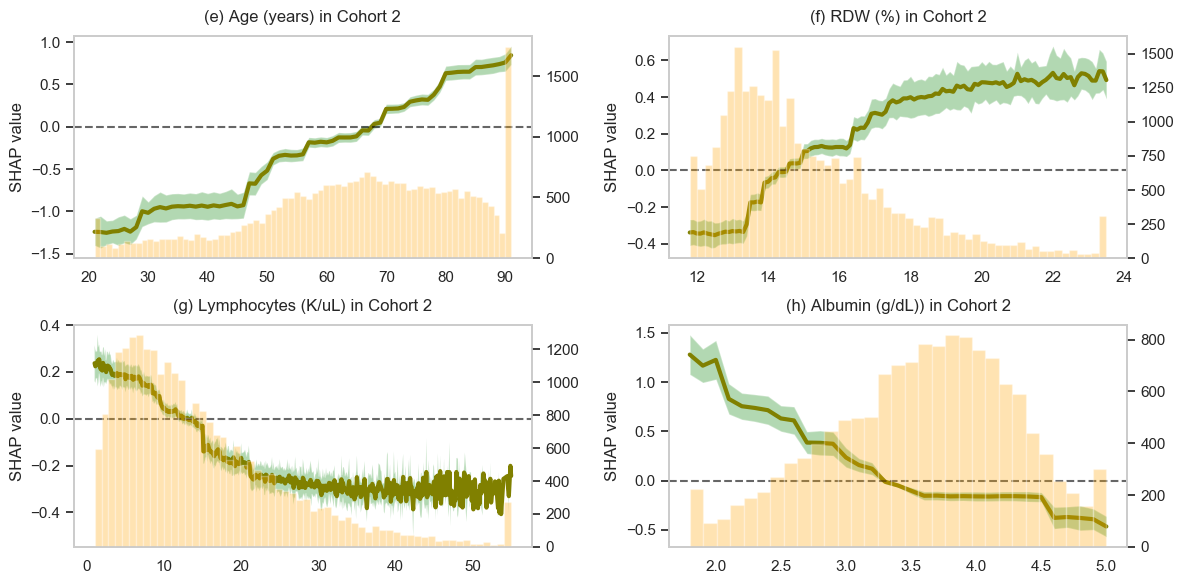

In [26]:

fig, axes = plt.subplots(2, 2, figsize=(12, 6))

########## axes[0,0] - Age ##########
fname = 'Age'
ifprocess = False
weight = 1
xminmax = False
bins = 71
x, s, xl, yl, sd, meanValue = get_values(fname, X, shap_values, ifprocess, weight)

axes[0, 0].fill_between(xl, yl + sd, yl - sd, facecolor='green', alpha=0.3)
axes[0, 0].plot(meanValue, 'olive', linewidth=3)
axes[0, 0].axhline(y=0, linestyle='--', color='black', alpha=0.6)
if xminmax:
    axes[0, 0].set_xlim(np.nanpercentile(x, 1), np.nanpercentile(x, 99))
axes[0, 0].set_title('(e) Age (years) in Cohort 2', fontsize=12, pad=10)
axes[0, 0].set_ylabel('SHAP value')
ax2 = axes[0, 0].twinx()
ax2.hist(x, bins=bins, histtype='bar', color='orange', alpha=0.3)


########## axes[0,1] - Lab_RDW ##########
fname = 'Lab_RDW'
ifprocess = False
weight = 1
xminmax = False
bins = 56
x, s, xl, yl, sd, meanValue = get_values(fname, X, shap_values, ifprocess, weight)

axes[0, 1].fill_between(xl, yl + sd, yl - sd, facecolor='green', alpha=0.3)
axes[0, 1].plot(meanValue, 'olive', linewidth=3)
axes[0, 1].axhline(y=0, linestyle='--', color='black', alpha=0.6)
if xminmax:
    axes[0, 1].set_xlim(np.nanpercentile(x, 1), np.nanpercentile(x, 99))
axes[0, 1].set_title('(f) RDW (%) in Cohort 2', fontsize=12, pad=10)
axes[0, 1].set_ylabel('SHAP value')
ax2 = axes[0, 1].twinx()
ax2.hist(x, bins=bins, histtype='bar', color='orange', alpha=0.3)

########## axes[1,0] - Lab_Lymphocytes ##########
fname = 'Lab_Lymphocytes'
ifprocess = False
weight = 1
xminmax = False
bins = 60
x, s, xl, yl, sd, meanValue = get_values(fname, X, shap_values, ifprocess, weight)

axes[1, 0].fill_between(xl, yl + sd, yl - sd, facecolor='green', alpha=0.3)
axes[1, 0].plot(meanValue, 'olive', linewidth=3)
axes[1, 0].axhline(y=0, linestyle='--', color='black', alpha=0.6)
if xminmax:
    axes[1, 0].set_xlim(np.nanpercentile(x, 1), np.nanpercentile(x, 99))
axes[1, 0].set_title('(g) Lymphocytes (K/uL) in Cohort 2', fontsize=12, pad=10)
axes[1, 0].set_ylabel('SHAP value')
ax2 = axes[1, 0].twinx()
ax2.hist(x, bins=bins, histtype='bar', color='orange', alpha=0.3)

########## axes[1,1] - Lab_Albumin ##########
fname = 'Lab_Albumin'
ifprocess = False
weight = 1
xminmax = False
bins = 31
x, s, xl, yl, sd, meanValue = get_values(fname, X, shap_values, ifprocess, weight)

axes[1, 1].fill_between(xl, yl + sd, yl - sd, facecolor='green', alpha=0.3)
axes[1, 1].plot(meanValue, 'olive', linewidth=3)
axes[1, 1].axhline(y=0, linestyle='--', color='black', alpha=0.6)
if xminmax:
    axes[1, 1].set_xlim(np.nanpercentile(x, 1), np.nanpercentile(x, 99))
axes[1, 1].set_title('(h) Albumin (g/dL)) in Cohort 2', fontsize=12, pad=10)
axes[1, 1].set_ylabel('SHAP value')
ax2 = axes[1, 1].twinx()
ax2.hist(x, bins=bins, histtype='bar', color='orange', alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

plt.savefig(save_path + 'figure_4features_MIMIC.png', dpi=300, bbox_inches='tight')

In [11]:
X['Lab_Albumin'].describe()

count    13950.000000
mean         3.567885
std          0.697273
min          1.800000
25%          3.100000
50%          3.600000
75%          4.100000
max          5.000000
Name: Lab_Albumin, dtype: float64